# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [149]:
import pandas as pd
import numpy as np
import math
import json
import pandas as pn
import numpy as np
import array as arrr
import statistics

from IPython.display import display

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression


from matplotlib import pyplot as plt
import seaborn as sns

import pydotplus
import io
import math
import seaborn as sns
import graphviz
from scipy import misc
import imageio
%matplotlib inline

In [88]:
%%html 
<h1> Data Exploration </h1><p>Downloading data, and making basic visualizations to draw some idea about customers characteristics.<p>

In [86]:
# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
# profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile= pd.read_excel('profileModified.xlsx', index=False)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
# print(profile['income'].isna().sum()/profile['income'].count())


profilePlt = profile.dropna()

profile = profile.drop([profile.columns[0]], axis="columns")

profile['income'] = profile['income'].fillna(round(profile['income'].mean()))
profile['income'] = profile['income'].astype(int)

# profile['age'].replace(118, round(profile['age'].mean()), inplace=True)
# profile['age'] = profile['age'].astype(int)

Text(0.5, 1.0, 'Figure 2: Customers Age Distribution')

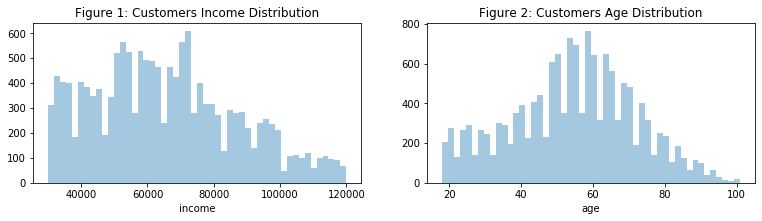

In [197]:
plt.figure(figsize=(20, 10))

plt.subplot(3,3,1)
sns.distplot(profilePlt['income'], kde = False, bins=50)
plt.title('Figure 1: Customers Income Distribution')

plt.subplot(3,3,2)
sns.distplot(profilePlt['age'], kde=False, bins=50)
plt.title('Figure 2: Customers Age Distribution')

In [92]:
%%html 
<h1> Data Preprocessing </h1><p>Merging the three files into one dataframe and modify the dataframe to fit the criteria of the problem scope, run visualizations on preprocessed data, to get general heuristics about customers and offers.<p>

In [89]:
""" Extracting needed values from 'value' comlumn dict """

tempList = []
for i in transcript['value']:
    tempList += [list(i.values())]
    
exctracted_offer_id = pd.DataFrame(tempList)
exctracted_offer_id.columns = ['event_value', '1']
exctracted_offer_id = exctracted_offer_id.drop(['1'], axis="columns")

transcript = pd.concat([transcript, exctracted_offer_id], axis="columns")
transcript = transcript.drop(['value'], axis = 'columns')

In [91]:
"""

following code sum the recieved, viewed and completed offers and add it as columns 
to the merged dataframe "inner_profile_transcript", also sums and validate that the completed offers are viewed 
by the customers in "completed_viewed_offers" column, there is no need to execute this code, all data generated 
from this code are saved in "profileModified.xlsx", "profileModified2.xlsx",
"portfolioModified.xlsx" and "inner_profile_transcript.xlsx".

"""

""" merging transcript, profile and portfolio on customer and offer id to get one comprehensive table """
# inner_profile_transcript = profile.merge(transcript, how='left', left_on=['id'], right_on=['person'])
# inner_profile_transcript = inner_profile_transcript.drop(['id'], axis="columns")
# inner_profile_transcript = inner_profile_transcript.merge(portfolio, how='left', left_on=['event_value'], right_on=['id'])
# inner_profile_transcript.to_excel("inner_profile_transcript.xlsx")

"""
Creating counter for received offers for each customer, with disregard of checking if customer viewed offer
befoer completion

"""
# profile['received_offers'] = profile['income']*0
# profile['completed_offers'] = profile['income']*0

""" for-loop for counting received offers """
# for i in profile['id']:
#     value = inner_profile_transcript[(inner_profile_transcript['event'] == 'offer viewed') & 
#       (inner_profile_transcript['person'] == i)]
    
    
#     value2 = inner_profile_transcript['event'][(inner_profile_transcript['event'] == 'offer completed') & 
#       (inner_profile_transcript['person'] == i)]
    
#     profile['received_offers'][profile['id'] == i] = len(value)
    
#     profile['completed_offers'][profile['id'] == i] = len(value2)

# profile.to_excel('profileModified.xlsx')


""" creating 'counter', 'completed_offers2' and completed_offers_by_type to store related values in later loop """

# inner_profile_transcript['counter'] = inner_profile_transcript['completed_offers']*0
# profile['completed_offers2'] = profile['income']*0
# portfolio['completed_offers_by_type'] = portfolio['reward']*0

""" two lists for completed offers and viewed offers """
# completed_offers1 = inner_profile_transcript[(inner_profile_transcript.event == "offer completed")]
# viewed_offers1 = inner_profile_transcript[(inner_profile_transcript.event == "offer viewed")]


"""
Creating counter for received offers for each customer, with regard of checking if customer viewed offer
befoer completion

"""
# for i in range(len(completed_offers1)):
#     person_offer = [completed_offers1.iloc[i]['person'], completed_offers1.iloc[i]['id']]
#     check = viewed_offers1.id[(viewed_offers1['person'] == person_offer[0]) & (viewed_offers1['id'] == person_offer[1])].unique()
#     inc = len(check)
#     print(inc)
    
#     profile['completed_offers2'][profile['id'] == person_offer[0]] += inc
#     portfolio['completed_offers_by_type'][portfolio['id'] == person_offer[1]] += inc
#     inner_profile_transcript.counter[(inner_profile_transcript.event == "offer received") & (inner_profile_transcript.person == person_offer[0])
#                             & (inner_profile_transcript.id == person_offer[1])] = inc

# inner_profile_transcript.to_excel("inner_profile_transcript3.xlsx")
# profile.to_excel('profileModified2.xlsx')
# portfolio.to_excel('portfolioModified.xlsx')

# inner_profile_transcript[inner_profile_transcript['person'] == '68be06ca386d4c31939f3a4f0e3dd783']
# inner_profile_transcript = pd.read_excel('inner_profile_transcript3.xlsx')
# profile[profile.id == '68be06ca386d4c31939f3a4f0e3dd783']
# inner_profile_transcript
""" End of Code """

' End of Code '

In [9]:
# reading modified merged and modified table from previous code
inner_profile_transcript = pd.read_excel('inner_profile_transcript3.xlsx')

In [95]:
%%html
<h3> Following graphs shows plots indecating various heuristics about the customers and completed offers (without viewing the offer): </h3><ul><li> <b>Completed offers: </b> By comparing completed offers by male customers (figure 1) and completed offers by female customers (figure 2). Although number of male customers are more than female customers, 88% of female customers completed an offer or more, where male customers completed an offer or more are 76%.</li><br><li> <b>Customers income: </b>Customers income distribution in figure 6 is little bit skewed to the right showing that most customer has low to average income.</li><br><li><b>Offer types: </b>Completed offers types "BOGO" and "discount" are 40% respectively, informational completed offers are 20%, which means people respond to offers whatever its type is as long as it has a reward. </li><br><li><b>Customers age: </b> customers age disrtibution (figure 10) shows almost normal distribution of customers age who completed one or more jobs, age group 45-65 completed most offers than other age groups, which shows that older people are oriented to complete offers</li><br><li><b>Conclusion: </b>Offer type diversity does not show clear indication of being a great factor in completing an offer, but customers completed more than one offer of "discount" offers than "BOGO" offers. Customers of age group 45-65 showed more activity in completing offers than other age groups. Number of customers completed one or more offers whos income average or below average are little bit larger than those who has higher than average income. Based on plots and numbers displayed below, customers gender is a decent indication of activeness after receiving an offer, although male customers have completed decent amount of offers, 88% of female customers have completed an offer or more.</li></ul>

Text(0.5, 1.0, 'Figure 6: Income Distribution of Customers who Completed Offers')

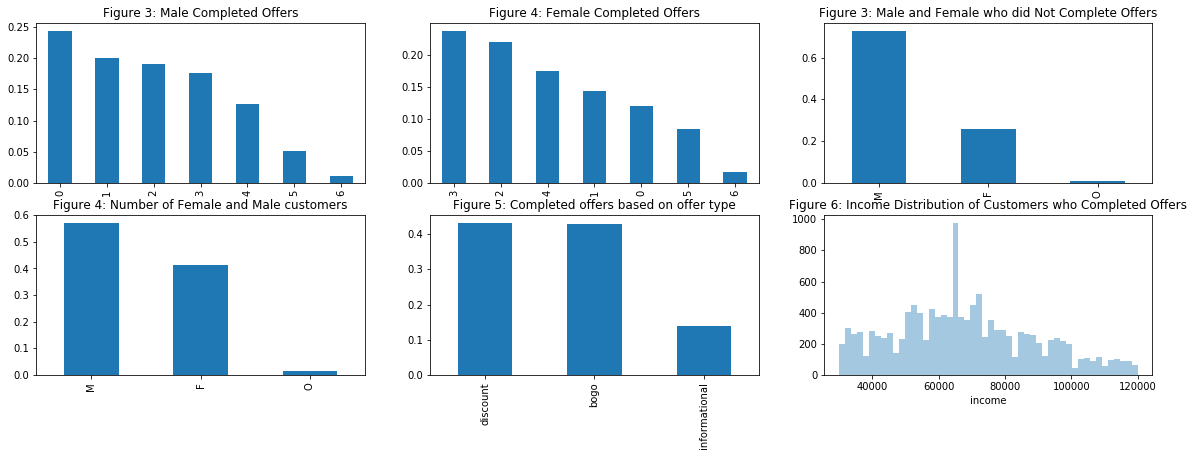

In [240]:
plt.figure(figsize=(20, 10))

plt.subplot(3,3,1)
profile.completed_offers[profile.gender == "M"].value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 3: Male Completed Offers")

plt.subplot(3,3,2)
profile.completed_offers[profile.gender == "F"].value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 4: Female Completed Offers")


plt.subplot(3,3,3)
profile.gender[(profile['completed_offers'] == 0)].value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 3: Male and Female who did Not Complete Offers")

plt.subplot(3,3,4)
profile.gender.value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 4: Number of Female and Male customers")

plt.subplot(3,3,5)
inner_profile_transcript.offer_type[inner_profile_transcript['completed_offers'] > 0].value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 5: Completed offers based on offer type")

plt.subplot(3,3,6)
sns.distplot(profile['income'][profile['completed_offers'] > 0], kde=False, bins=50)
plt.title("Figure 6: Income Distribution of Customers who Completed Offers")

Text(0.5, 1.0, 'Figure 11: Channels of Completed Offers')

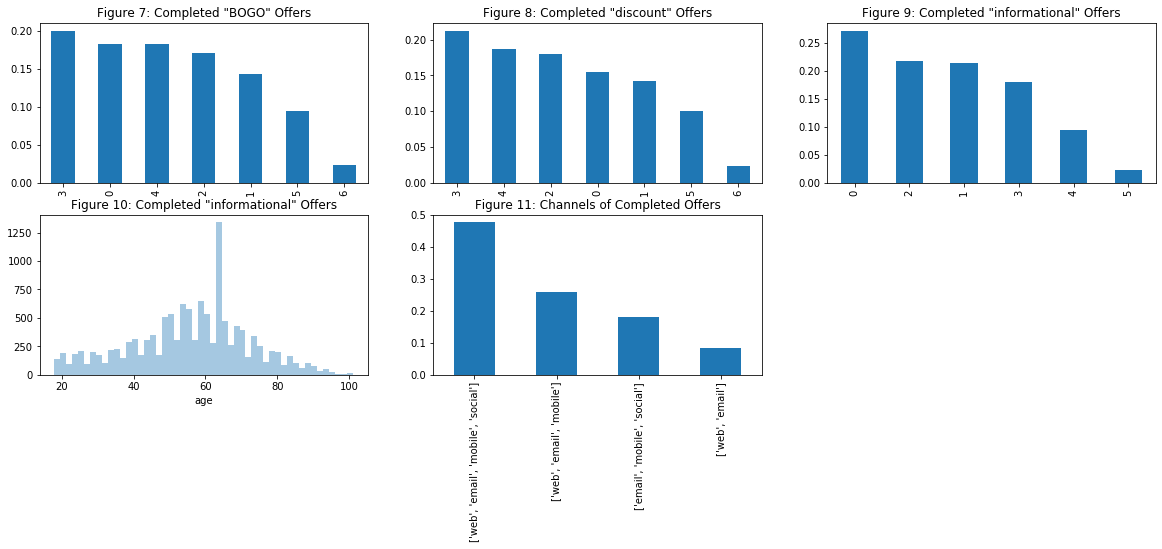

In [12]:
plt.figure(figsize=(20, 10))

plt.subplot(3,3,1)
inner_profile_transcript.completed_offers[inner_profile_transcript.offer_type == "bogo"].value_counts(normalize=True).plot(kind="bar")
plt.title('Figure 7: Completed "BOGO" Offers')

plt.subplot(3,3,2)
inner_profile_transcript.completed_offers[inner_profile_transcript.offer_type == "discount"].value_counts(normalize=True).plot(kind="bar")
plt.title('Figure 8: Completed "discount" Offers')

plt.subplot(3,3,3)
inner_profile_transcript.completed_offers[inner_profile_transcript.offer_type == "informational"].value_counts(normalize=True).plot(kind="bar")
plt.title('Figure 9: Completed "informational" Offers')

plt.subplot(3,3,4)
sns.distplot(profile['age'][profile['completed_offers'] > 0], kde=False, bins=50)
plt.title('Figure 10: Completed "informational" Offers')

plt.subplot(3,3,5)
inner_profile_transcript.channels[inner_profile_transcript.completed_offers > 0].value_counts(normalize=True).plot(kind="bar")
plt.title('Figure 11: Channels of Completed Offers')

In [13]:
income_mean = round(profile.income[profile['completed_offers'] > 0].mean())
completed_offer_below_above_income_mean = [sum(profile.id[(profile['income'] < income_mean) & (profile['completed_offers'] > 0)].value_counts()), sum(profile.id[(profile['income'] > income_mean) & (profile['completed_offers'] > 0)].value_counts())]
completed_offer_based_on_gender = [len(profile[(profile['gender'] == "F") & (profile['completed_offers'] > 0)]), len(profile[(profile['gender'] == "M") & (profile['completed_offers'] > 0)])]


transaction_without_offer = len(inner_profile_transcript.loc[inner_profile_transcript['received_offers'] == 0])
transaction_without_offer2 = len(inner_profile_transcript.loc[(inner_profile_transcript['received_offers'] == 0) & (inner_profile_transcript['gender'] == "F")])
transaction_without_offer3 = len(inner_profile_transcript.loc[(inner_profile_transcript['received_offers'] == 0) & (inner_profile_transcript['gender'] == "M")])


female_customers = len(profile.gender[profile.gender == "F"])
male_customers = len(profile.gender[profile.gender == "M"])


complete_without_offer = len(inner_profile_transcript[(inner_profile_transcript['completed_offers'] > 0) & (inner_profile_transcript['received_offers'] == 0)])


number_of_bogo = len(inner_profile_transcript[inner_profile_transcript.offer_type == "bogo"])
number_of_discount = len(inner_profile_transcript[inner_profile_transcript.offer_type == "discount"])
number_of_informational = len(inner_profile_transcript[inner_profile_transcript.offer_type == "informational"])

offer_type_bogo = len(inner_profile_transcript[(inner_profile_transcript['offer_type'] == "bogo") & (inner_profile_transcript['completed_offers'] == 0)])
offer_type_discount = len(inner_profile_transcript[(inner_profile_transcript['offer_type'] == "discount") & (inner_profile_transcript['completed_offers'] == 0)])
offer_type_informational = len(inner_profile_transcript[(inner_profile_transcript['offer_type'] == "informational") & (inner_profile_transcript['completed_offers'] == 0)])


print("Number of female customers: ", female_customers)
print("Number of male customers: ", male_customers)
print("(all bogo offers) ", number_of_bogo, "(all discount offers) ", number_of_discount, "(all informational offers) ", number_of_informational)
print("(bogo offers not completed) ", offer_type_bogo, "(discount offers not completed) ", offer_type_discount, "(informational offers not completed) ", offer_type_informational)
print("Completed offers below income mean: ", completed_offer_below_above_income_mean[0])
print("Completed offers below income mean: ", completed_offer_below_above_income_mean[1])
print("Completed offers from female customers: ", completed_offer_based_on_gender[0],  "(", round(completed_offer_based_on_gender[0]/female_customers, 2),"%)")
print("Completed offers from male customers: ", completed_offer_based_on_gender[1], "(", round(completed_offer_based_on_gender[1]/male_customers, 2),"%)")
print("Completed offers without receiving an offer: ", complete_without_offer)
print("Transaction made without offers from female customers: ", transaction_without_offer2, "(", round(transaction_without_offer2/female_customers,3), "%)")
print("Transaction made without offers from male customers: ", transaction_without_offer3, "(", round(transaction_without_offer2/male_customers,3), "%)")


Number of female customers:  6129
Number of male customers:  8484
(all bogo offers)  71617 (all discount offers)  69898 (all informational offers)  26066
(bogo offers not completed)  13147 (discount offers not completed)  10809 (informational offers not completed)  7084
Completed offers below income mean:  6946
Completed offers below income mean:  5828
Completed offers from female customers:  5391 ( 0.88 %)
Completed offers from male customers:  6416 ( 0.76 %)
Completed offers without receiving an offer:  0
Transaction made without offers from female customers:  16 ( 0.003 %)
Transaction made without offers from male customers:  3 ( 0.002 %)


In [100]:
%%html
<h3> Following graphs shows plots indecating various heuristics about the customers and completed offers (with viewing the offer): </h3><ul><li> <b>Completed offers: </b> By comparing completed offers by male customers (figure 1) and completed offers by female customers (figure 2). Although number of male customers are more than female customers, 84% of female customers completed an offer or more, where male customers completed an offer or more are 74%, somewhat minor difference between previous heuristic</li><br><li> <b>Customers income: </b>Customers income distribution in figure 6 is same as before, little bit skewed to the right showing that most customer has low to average income.</li><br><li><b>Offer types: </b>Completed offers types "BOGO" and "discount" are 50% respectively, there is no completed informational type offer, which makes sense, these kind of offers are completed by customers without viewing company website, and basically buying a certain product will complete an offer.. </li><br><li><b>Customers age: </b> customers age disrtibution (figure 10) also shows almost normal distribution of customers age who completed one or more jobs, age group 45-65 completed most offers than other age groups, which shows that older people are oriented to complete offers</li><br><li><b>Conclusion: </b>Offer type diversity does not show clear indication of being a great factor in completing an offer, but customers completed more than one offer of "discount" offers than "BOGO" offers. Customers of age group 45-65 showed more activity in completing offers than other age groups. Number of customers completed one or more offers whos income average or below average are little bit larger than those who has higher than average income. Based on plots and numbers displayed below, customers gender is a decent indication of activeness after receiving an offer, although male customers have completed decent amount of offers, 84% of female customers have completed an offer or more.</li></ul>

In [15]:
profile_modified = pd.read_excel('profileModified2.xlsx')

Text(0.5, 1.0, 'Figure 6: Income Distribution of Customers who Completed Offers')

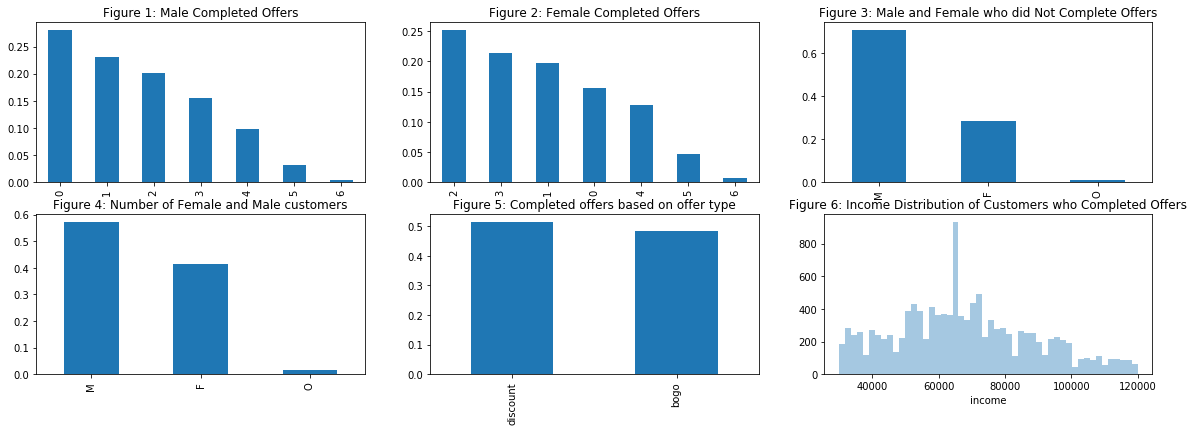

In [99]:
plt.figure(figsize=(20, 10))

plt.subplot(3,3,1)
profile_modified.completed_offers2[(profile_modified.gender == "M")].value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 1: Male Completed Offers")

plt.subplot(3,3,2)
profile_modified.completed_offers2[profile_modified.gender == "F"].value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 2: Female Completed Offers")

plt.subplot(3,3,3)
profile_modified.gender[(profile_modified['completed_offers2'] == 0)].value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 3: Male and Female who did Not Complete Offers")

plt.subplot(3,3,4)
profile_modified.gender.value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 4: Number of Female and Male customers")

plt.subplot(3,3,5)
inner_profile_transcript.offer_type[inner_profile_transcript['counter'] > 0].value_counts(normalize=True).plot(kind="bar")
plt.title("Figure 5: Completed offers based on offer type")

plt.subplot(3,3,6)
sns.distplot(profile_modified['income'][profile_modified['completed_offers2'] > 0], kde=False, bins=50)
plt.title("Figure 6: Income Distribution of Customers who Completed Offers")

Text(0.5, 1.0, 'Figure 10: Channels of Completed Offers')

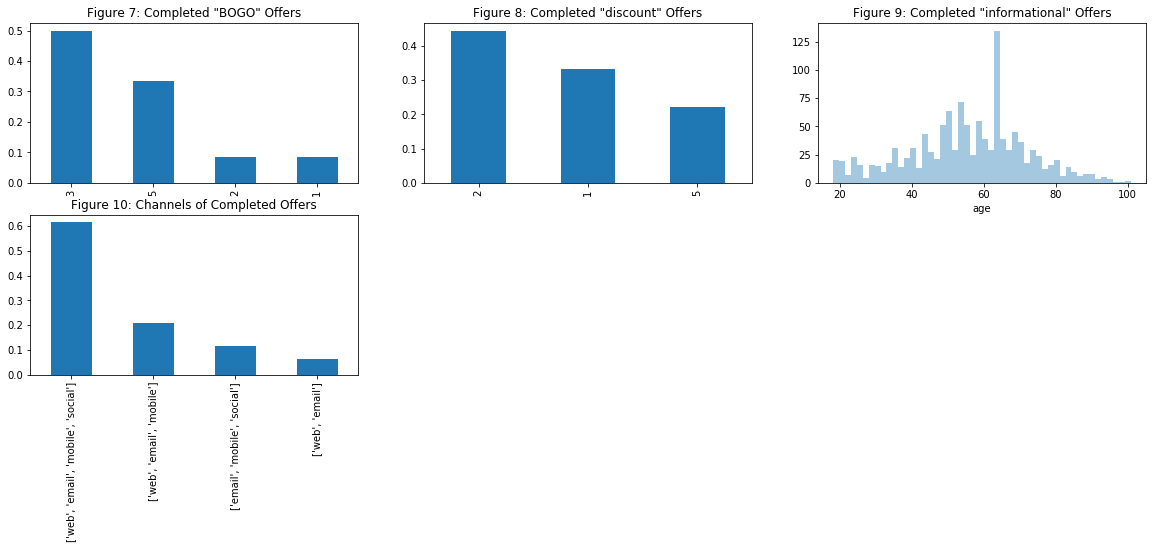

In [17]:
plt.figure(figsize=(20, 10))

plt.subplot(3,3,1)
inner_profile_transcript.completed_offers2[(inner_profile_transcript.completed_offers2 != 0) & (inner_profile_transcript.offer_type == "bogo") & (inner_profile_transcript['counter'] > 0)].value_counts(normalize=True).plot(kind="bar")
plt.title('Figure 7: Completed "BOGO" Offers')

plt.subplot(3,3,2)
inner_profile_transcript.completed_offers2[(inner_profile_transcript.offer_type == "discount") & (inner_profile_transcript.completed_offers2 != 0) & (inner_profile_transcript['counter'] > 0)].value_counts(normalize=True).plot(kind="bar")
plt.title('Figure 8: Completed "discount" Offers')

# plt.subplot(3,3,3)
# inner_profile_transcript.completed_offers2[(inner_profile_transcript.offer_type == "informational") & (inner_profile_transcript['counter'] > 0)].value_counts(normalize=True).plot(kind="bar")
# plt.title('Figure 9: Completed "informational" Offers')

plt.subplot(3,3,3)
sns.distplot(profile_modified['age'][(profile_modified['completed_offers2'] > 0) & (inner_profile_transcript['counter'] > 0)], kde=False, bins=50)
plt.title('Figure 9: Completed "informational" Offers')

plt.subplot(3,3,4)
inner_profile_transcript.channels[(inner_profile_transcript['counter'] > 0)].value_counts(normalize=True).plot(kind="bar")
plt.title('Figure 10: Channels of Completed Offers')

In [18]:
"""
here numbers and statistics about completed offers based on various factors mentioned to have further information to 
determine what makes the customers complete an offer. 

"""

income_mean = round(profile_modified.income[profile_modified['completed_offers2'] > 0].mean())
completed_offer_below_above_income_mean = [sum(profile_modified.id[(profile['income'] < income_mean) & (profile_modified['completed_offers2'] > 0)].value_counts()), sum(profile_modified.id[(profile_modified['income'] > income_mean) & (profile_modified['completed_offers2'] > 0)].value_counts())]
completed_offer_based_on_gender = [len(profile_modified[(profile_modified['gender'] == "F") & (profile_modified['completed_offers2'] > 0)]), len(profile_modified[(profile_modified['gender'] == "M") & (profile_modified['completed_offers2'] > 0)])]


transaction_without_offer = len(inner_profile_transcript.loc[inner_profile_transcript['received_offers'] == 0])
transaction_without_offer2 = len(inner_profile_transcript.loc[(inner_profile_transcript['received_offers'] == 0) & (inner_profile_transcript['gender'] == "F")])
transaction_without_offer3 = len(inner_profile_transcript.loc[(inner_profile_transcript['received_offers'] == 0) & (inner_profile_transcript['gender'] == "M")])


female_customers = len(profile.gender[profile.gender == "F"])
male_customers = len(profile.gender[profile.gender == "M"])


complete_without_offer = len(inner_profile_transcript[(inner_profile_transcript['completed_offers2'] > 0) & (inner_profile_transcript['received_offers'] == 0)])


number_of_bogo = len(inner_profile_transcript[inner_profile_transcript.offer_type == "bogo"])
number_of_discount = len(inner_profile_transcript[inner_profile_transcript.offer_type == "discount"])
number_of_informational = len(inner_profile_transcript[inner_profile_transcript.offer_type == "informational"])

offer_type_bogo = len(inner_profile_transcript[(inner_profile_transcript['offer_type'] == "bogo") & (inner_profile_transcript['completed_offers2'] == 0)])
offer_type_discount = len(inner_profile_transcript[(inner_profile_transcript['offer_type'] == "discount") & (inner_profile_transcript['completed_offers2'] == 0)])
offer_type_informational = len(inner_profile_transcript[(inner_profile_transcript['offer_type'] == "informational") & (inner_profile_transcript['completed_offers2'] == 0)])


print("Number of female customers: ", female_customers)
print("Number of male customers: ", male_customers)
print("(all bogo offers) ", number_of_bogo, "(all discount offers) ", number_of_discount, "(all informational offers) ", number_of_informational)
print("(bogo offers not completed) ", offer_type_bogo, "(discount offers not completed) ", offer_type_discount, "(informational offers not completed) ", offer_type_informational)
print("Completed offers below income mean: ", completed_offer_below_above_income_mean[0])
print("Completed offers below income mean: ", completed_offer_below_above_income_mean[1])
print("Completed offers from female customers: ", completed_offer_based_on_gender[0],  "(", round(completed_offer_based_on_gender[0]/female_customers, 2),"%)")
print("Completed offers from male customers: ", completed_offer_based_on_gender[1], "(", round(completed_offer_based_on_gender[1]/male_customers, 2),"%)")
print("Completed offers without receiving an offer: ", complete_without_offer)
print("Transaction made without offers from female customers: ", transaction_without_offer2, "(", round(transaction_without_offer2/female_customers,3), "%)")
print("Transaction made without offers from male customers: ", transaction_without_offer3, "(", round(transaction_without_offer2/male_customers,3), "%)")

Number of female customers:  6129
Number of male customers:  8484
(all bogo offers)  71617 (all discount offers)  69898 (all informational offers)  26066
(bogo offers not completed)  71578 (discount offers not completed)  69859 (informational offers not completed)  26060
Completed offers below income mean:  6621
Completed offers below income mean:  5581
Completed offers from female customers:  5173 ( 0.84 %)
Completed offers from male customers:  6105 ( 0.72 %)
Completed offers without receiving an offer:  0
Transaction made without offers from female customers:  16 ( 0.003 %)
Transaction made without offers from male customers:  3 ( 0.002 %)


In [207]:
# reading preprocessed data

preprocessed_data = pd.read_excel('inner_profile_transcript3.xlsx')

# we are interested in received offers rows only containing columns about customers, offer, and if the offer was viewed and
# completed in counter column where 0 indicating not completed and 1 indicating completed

preprocessed_data = preprocessed_data[preprocessed_data['event'] == "offer received"]

In [208]:
# droping column that has no benefit for the classifier, and keeping features to be fitted
preprocessed_data = preprocessed_data.drop(['completed_offers', 'completed_offers2', 'event', 'person', 'time', 'received_offers', 'completed_offers_by_type', 'event_value', 'channels', 'difficulty', 'id'], axis='columns')

In [209]:
preprocessed_data = preprocessed_data.drop(preprocessed_data.columns[0], axis="columns")

In [210]:
# exctracted features
preprocessed_data.columns = ['age', 'gender', 'income', 'offer_type', 'duration', 'reward', 'completed']

In [211]:
features = preprocessed_data

In [212]:
# here we use label encoder to transform catagorical data to numbers, and mean normalization for feature scaling

features['gender'] = features['gender'].fillna('none')

for i in features.columns:
    if(i == "completed"):
        continue
    if(type(features.loc[features.index[0], i]) == str):
        features[i] = LabelEncoder().fit_transform(features[i])
    
    
for i in features.columns:  
    if(type(features.loc[features.index[0], i]) != str and i != "completed"):
        features.loc[:, i] = (features[i] - features[i].mean())/(max(features[i]) - min(features[i]))

features

,age,gender,income,offer_type,duration,reward,completed
0,0.090658,0.697204,0.000323,0.070899,0.100056,-0.220161,0
2,0.090658,0.697204,0.000323,0.499471,0.100056,0.079839,0
5,0.090658,0.697204,0.000323,0.499471,0.100056,-0.220161,1
9,0.090658,0.697204,0.000323,0.070899,0.100056,-0.120161,1
16,0.090658,0.697204,0.000323,0.499471,0.100056,-0.220161,1
23,-0.005728,-0.302796,0.518046,0.070899,-0.399944,0.079839,0
24,-0.005728,-0.302796,0.518046,-0.357672,0.600056,-0.420161,0
28,0.090658,0.697204,0.000323,0.070899,-0.399944,0.079839,0
33,0.090658,0.697204,0.000323,-0.500529,0.600056,-0.420161,0
37,0.235236,-0.302796,0.384712,0.070899,-0.399944,0.079839,1


In [237]:
# splitting data to train and test data

train, test = train_test_split(features, test_size = 0.30)

x_train = train.drop(['completed'], axis="columns")
y_train = train.completed

x_test = test.drop(['completed'], axis="columns")
y_test = test.completed

In [238]:
# here the decision tree classifier are created, max depth was set to 3 to be able to visualize the tree, because the
# tree was pretty large, and we only interested to see the first couple splits to know how the algorithm decided 
# what are the most important feature 

feature = ['age', 'gender', 'income', 'duration', 'offer_type', 'reward']
clf = DecisionTreeClassifier()
# clf = LogisticRegression()
dt = clf.fit(x_train, y_train)


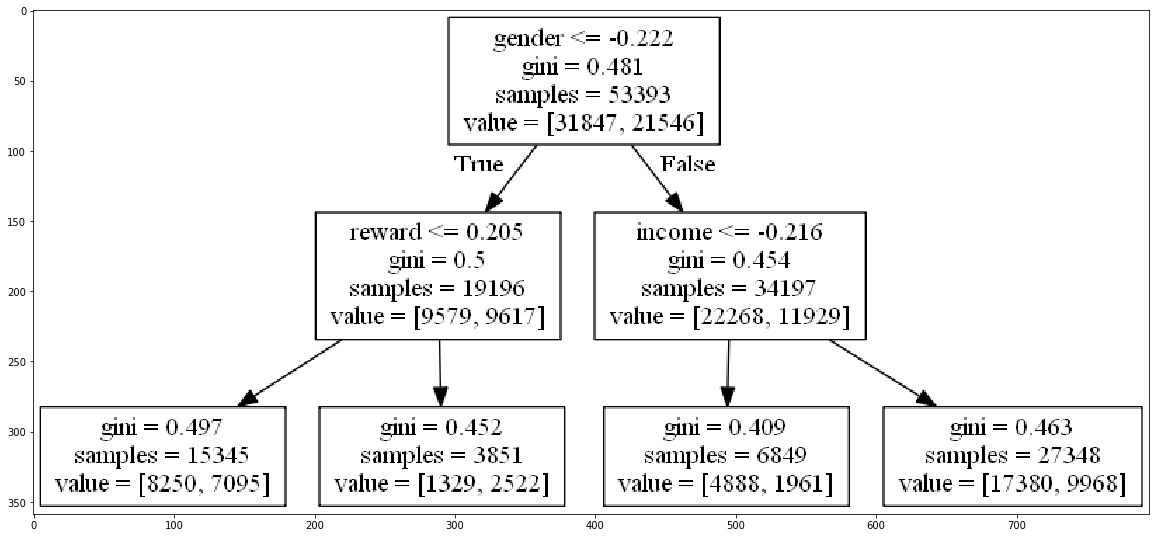

In [221]:
def show_tree(tree, feature, path):
    f = io.StringIO()
    export_graphviz(tree, out_file = f, feature_names = feature)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = imageio.imread(path)
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.imshow(img)
show_tree(dt, feature, 'decc_tree_01.png')

In [239]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# here the classifier accuracy measured using f-measure

y = dt.predict(x_test)
# print(lr2.score(x_test, y_test))

# y_true = y_test
# y_pred = 
# print(lr2.predict(x_test))
print(classification_report(y_test, y))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80     13697
           1       0.71      0.65      0.68      9187

    accuracy                           0.75     22884
   macro avg       0.74      0.74      0.74     22884
weighted avg       0.75      0.75      0.75     22884

